In [1]:
from osgeo import gdal, osr
import numpy as np
import matplotlib.pyplot as plt


In [37]:
df

,A,B,C
0,NaN,0.000000,0.000000
1,NaN,1.098612,1.098612
2,NaN,0.000000,0.000000
3,NaN,0.000000,0.000000
4,NaN,1.098612,1.098612
5,1.386294,1.386294,1.386294
6,1.609438,1.609438,1.609438
7,1.791759,1.791759,1.791759


In [40]:
df.A.mean()

1.5958305809273485

In [2]:
row=1800; col=3600
a= np.ones((row, col, 365), dtype=np.float16)

In [4]:
a.itemsize*a.size

4730400000

In [2]:
gauge_1= gdal.Open('./rainfall_analysis/gauge4km/ST2gg2017082500.Grb.tif')
gauge_2= gdal.Open('./cleaned/gauge4km/ST2gg2017082500.Grb.tif')



In [18]:
import pandas as pd
df= pd.DataFrame({'A':[np.nan,np.nan,np.nan,np.nan,np.nan,4,5,6],
             'B':[2,3,1,2,3,4,5,6],
             'C':[2,3,1,2,3,4,5,6]})

# df.clip(lower=2, inplace= True)
df= df.apply(np.log)
df[df<1]=0

In [29]:
import multiprocessing
pool= multiprocessing.Pool(4)

def single(i):
    j= i+1
    m= i+2
    return j,m

inputs= range(10)
a= pool.map(single, inputs)

a

[(1, 2),
 (2, 3),
 (3, 4),
 (4, 5),
 (5, 6),
 (6, 7),
 (7, 8),
 (8, 9),
 (9, 10),
 (10, 11)]

In [30]:
np.log(0.01)

-4.605170185988091

In [7]:
gauge_2.ReadAsArray()[np.isnan(gauge_2.ReadAsArray())]

array([], dtype=float32)

In [2]:
# explotionary analysis
gauge_pth= './rainfall_analysis/gauge4km/ST2gg2017082500.Grb.tif'
sat_pth= './rainfall_analysis/GPMrt1H4kmw/nimerg20170825S000000.tif'
rad_pth= './rainfall_analysis/mrmsrt1H4kmw/nPrecipRate_00.00_20170825-000000.grib2-var0-z0.tif'

gauge= gdal.Open(gauge_pth)
sat= gdal.Open(sat_pth)
radar= gdal.Open(rad_pth)

In [3]:
#get projection:
def projection(src):
    return src.GetProjection()


In [4]:
print('gauge projection: ', projection(gauge))
print('satellite projection: ', projection(sat))
print('radar projection: ', projection(radar))

gauge projection:  GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]]
satellite projection:  GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]]
radar projection:  GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]]


In [109]:
gauge_data= gauge.ReadAsArray()
sat_data= sat.ReadAsArray()
radar_data= radar.ReadAsArray()

In [17]:
print('gauge shape:',gauge_data.shape)
print('satellite shape:',sat_data.shape)
print('radar shape:', radar_data.shape)

gauge shape: (215, 294)
satellite shape: (218, 301)
radar shape: (215, 296)


In [11]:
#xoffset, px_w, rot1, yoffset, rot2 ,px_h = ds.GetGeoTransform()

def getGeoTransform(src):
    return src.GetGeoTransform()
print(getGeoTransform(gauge))
print(getGeoTransform(radar))
print(getGeoTransform(sat))

(-101.0, 0.04421768707482993, 0.0, 35.0, 0.0, -0.044186046511627906)
(-101.101724138, 0.04421052631579, 0.0, 35.0, 0.0, -0.044186047)
(-101.100006104, 0.04421052631579, 0.0, 34.999855042, 0.0, -0.044186047)


In [139]:
(25.8-35)/num_rows

-0.043809523809523805

In [142]:
import affine
#construct a new array with shape (210,294)
num_rows= 210
num_cols= 294
width= (101.0-88.05)/num_cols
height= -(25.8-35)/num_rows
begX= -101.0
begY= 35.0
rot1= 0
rot2= 0
# array shape (209,293)
#posX = px_w * x + rot1 * y + xoffset
#posY = rot2 * x + px_h * y + yoffset

def initial_estimate(data_source):
    global width, rot1, begX, rot2, height, begY
    xoffset, px_w, rot1, yoffset, rot2 , px_h = getGeoTransform(data_source)
    forward_transform =  \
        affine.Affine.from_gdal(*data_source.GetGeoTransform())
    reverse_transform = ~forward_transform
    px, py = reverse_transform * (begX, begY)
    px, py = int(px + 0.5), int(py + 0.5)
        
    return py

def get_value(src, row, col):
    return src.ReadAsArray()[row, col]

def get_array(src):
    global width, rot1, begX, rot2, height, begY, num_cols, num_rows
    first= True
    new_arr= np.zeros((num_rows,num_cols), dtype=np.float64)
    for i in range(num_rows):
        if first:
            prev_col=initial_estimate(src)-1
            first= False
        _temp= 0
        for j in range(num_cols):
            x= i*width+begX
            y= -height*j+begY
            val, row, col= retrieve_pixel_value(src, (x, y))
            new_arr[i,j]= val
            if col-prev_col!=1 and j!=0:
                _temp= get_value(src, row, prev_col)
                if _temp>val: new_arr[i,j]=_temp
                prev_col= col
#                 print(prev_col, col)
            else:
                prev_col= col
    
    return new_arr
        
        

def resample(src, posX, posY):
    # get CRS from dataset
    crs = osr.SpatialReference()
    crs.ImportFromWkt(src.GetProjectionRef())
    xoffset, px_w, rot1, yoffset, rot2 ,px_h = getGeoTransform(src)
    row, col= int((posY-yoffset)//px_h), int((posX-xoffset)//px_w)
    if col< 0:
        interval_col= -col
    else:
        interval_col=0
    col+=interval_col
    if row< 0:
        interval_row= -row
    else:
        interval_row= 0
    row+= interval_row
    # create lat/long crs with WGS84 datum
#     crsGeo = osr.SpatialReference()
#     crsGeo.ImportFromEPSG(4326) # 4326 is the EPSG id of lat/long crs 
#     t = osr.CoordinateTransformation(crs, crsGeo)
#     (lat, long, z) = t.TransformPoint(posX, posY)
    data= src.ReadAsArray()
    return data[row, col], row, col



def retrieve_pixel_value(data_source, geo_coord):
    """Return floating-point value that corresponds to given point."""
    x, y = geo_coord[0], geo_coord[1]
    forward_transform =  \
        affine.Affine.from_gdal(*data_source.GetGeoTransform())
    reverse_transform = ~forward_transform
    px, py = reverse_transform * (x, y)
    px, py = int(px + 0.5), int(py + 0.5)
    pixel_coord = px, py

    data_array = np.array(data_source.GetRasterBand(1).ReadAsArray())
    return data_array[pixel_coord[0]][pixel_coord[1]], px, py

In [143]:
gauge_new= get_array(gauge)
radar_new= get_array(radar)
sat_new= get_array(sat)

In [114]:
sat_new.max()

31.01431655883789

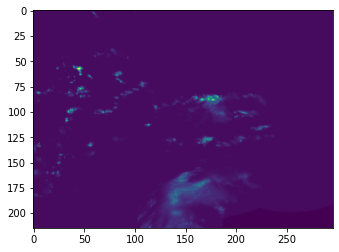

In [121]:
plt.imshow(radar_data)

In [124]:
gauge_data.min()

-9999.0

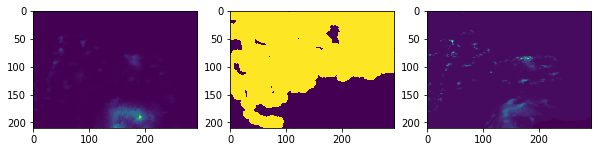

In [144]:
fig, ax= plt.subplots(1,3,figsize=(10,8))
ax[0].imshow(sat_new)
ax[1].imshow(gauge_new)
ax[2].imshow(radar_new)

In [148]:
radar_data.min()

-1.0

In [136]:
# write .tif file
geo_trans= (begX, width, rot1, begY, height, rot2)

def write(new_arr,old_obj, dst):
    
    global geo_trans
    rows, cols= new_arr.shape
    driver= gdal.GetDriverByName("GTiff")
    outdata = driver.Create(dst, cols, rows, 1, gdal.GDT_Float32)
    crs= old_obj.GetProjection()
    outdata.SetGeoTransform(geo_trans)
    outdata.SetProjection(crs)
    outdata.GetRasterBand(1).WriteArray(new_arr)

In [146]:
write(radar_new, radar, 'radar_new.tif')

In [151]:
getGeoTransform(gdal.Open('gauge_new.tif'))

(-101.0, 0.04404761904761906, 0.0, 35.0, -0.043809523809523805, 0.0)

In [54]:
import affine

def retrieve_pixel_value(geo_coord, data_source):
    """Return floating-point value that corresponds to given point."""
    x, y = geo_coord[0], geo_coord[1]
    forward_transform =  \
        affine.Affine.from_gdal(*data_source.GetGeoTransform())
    reverse_transform = ~forward_transform
    px, py = reverse_transform * (x, y)
    px, py = int(px + 0.5), int(py + 0.5)
    pixel_coord = px, py
    print(pixel_coord)

    data_array = np.array(data_source.GetRasterBand(1).ReadAsArray())
    return data_array[pixel_coord[0]][pixel_coord[1]]

In [28]:
posX= [begX+i*width for i in range(294)]
posY= [begY+j*height for j in range(210)]

In [29]:
posY[-1]

25.765116386000003

In [32]:
def GetExtent(src):
    ''' Return list of corner coordinates from a geotransform

        @type gt:   C{tuple/list}
        @param gt: geotransform
        @type cols:   C{int}
        @param cols: number of columns in the dataset
        @type rows:   C{int}
        @param rows: number of rows in the dataset
        @rtype:    C{[float,...,float]}
        @return:   coordinates of each corner
    '''
    xoffset, px_w, rot1, yoffset, rot2 ,px_h = getGeoTransform(src)
    data= src.ReadAsArray()
    rows, cols= data.shape
    left= xoffset
    right= xoffset+px_w*cols
    upper= yoffset
    lower= yoffset+px_h*rows
    
    return {'left': left, 'right': right, 'upper':upper, 'lower':lower}


In [34]:
print('gauge extent : %s'%GetExtent(gauge))
print('radar extent : %s'%GetExtent(radar))
print('sat extent : %s'%GetExtent(sat))

gauge extent : {'left': -101.0, 'right': -88.0, 'upper': 35.0, 'lower': 25.5}
radar extent : {'left': -101.101724138, 'right': -88.01540834852615, 'upper': 35.0, 'lower': 25.499999895000002}
sat extent : {'left': -101.100006104, 'right': -87.79263768294722, 'upper': 34.999855042, 'lower': 25.367296795999998}


In [49]:
radar_data[0,100]

1.2708863

In [58]:
~affine.Affine.from_gdal(*radar.GetGeoTransform())*(-101.0,35)

(2.300903121428746, 0.0)

In [12]:
from tc import TripleCollocation

In [14]:
tc= TripleCollocation()
RMSE, CC= tc.main()

NameError: name 'thread1' is not defined